# Some imports and helper code

In [1]:
import torch
import numpy as np
import torch.nn as nn
import networkx as nx
from spectrum_attack import spectrum_attack
import matplotlib.pylab as plt

np.random.seed(1)

In [2]:
def plot_results(results, alphas):
    plt.figure()
    results[['lambda', 'lambda_sub', 'centrality']].plot(kind='line')
    plt.xlabel('iterations')
    title_template = r'$\alpha_1={:.2f}, \alpha_2={:.2f}, \alpha_3={:.2f}$'
    plt.title(title_template.format(*alphas))
    
    
def plot_adj_matrices(graph, final_adj):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(nx.to_numpy_array(graph))
    axes[0].set_title('before attack')
    axes[1].imshow(final_adj.A)
    axes[1].set_title('after attack')

# Run the attack on a BA network (old nodes)

In this experiment, I'll use a subgraph made of three nodes that are 'old' in the BA growth process, i.e., nodes of large degree.

In [3]:
graph = nx.barabasi_albert_graph(100, 2)
subgraph = [1, 2, 3]
alphas = [0.5, 0.3, 0.2]
results, final_adj = spectrum_attack(graph, subgraph, alphas, verbose=True)

(0) utility: 1.919, lambda_1: 7.516, lambda_1_S: 1.414
(10) utility: 2.007, lambda_1: 7.565, lambda_1_S: 1.331
(20) utility: 2.132, lambda_1: 7.651, lambda_1_S: 1.347
(30) utility: 2.251, lambda_1: 7.745, lambda_1_S: 1.361
(40) utility: 2.327, lambda_1: 7.816, lambda_1_S: 1.278
(50) utility: 2.441, lambda_1: 7.920, lambda_1_S: 1.295
(60) utility: 2.517, lambda_1: 7.999, lambda_1_S: 1.221
(70) utility: 2.634, lambda_1: 8.107, lambda_1_S: 1.249
(80) utility: 2.751, lambda_1: 8.219, lambda_1_S: 1.281
(90) utility: 2.785, lambda_1: 8.290, lambda_1_S: 1.122


## Plot the behavior of $\lambda_1$ and $\lambda_1^S$

<Figure size 432x288 with 0 Axes>

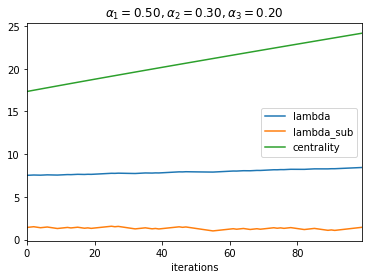

In [4]:
plot_results(results, alphas)

What the attacker wants to do is increase the green and orange lines, while maintaining the blue line as constant as possible. In this plot, the blue line seems to increase more slowly than the other two, which means we are on the right track, though not quite there yet.

## Plot the original and final adjacency matrices

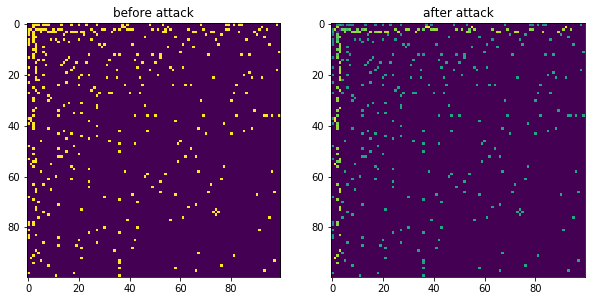

In [5]:
plot_adj_matrices(graph, final_adj)

Note that the weights of most edges has decreased, while the edges incident to (and between) nodes in the subgraph have increased weights (see top left corner of the matrix after attack).

# Run attack on a BA network (new nodes)

In this experiment, I'll use a subgraph induced by the egonet of a random node. Since the node is random, it is likely to have low degree.

In [6]:
graph = nx.barabasi_albert_graph(100, 2)
center = np.random.choice(range(graph.order()))
subgraph = list(graph.neighbors(center)) + [center]
alphas = [0.5, 0.3, 0.2]
results, final_adj = spectrum_attack(graph, subgraph, alphas, verbose=True)

(0) utility: -0.134, lambda_1: 6.846, lambda_1_S: 2.000
(10) utility: 0.090, lambda_1: 6.687, lambda_1_S: 2.295
(20) utility: 0.159, lambda_1: 6.536, lambda_1_S: 2.289
(30) utility: 0.369, lambda_1: 6.409, lambda_1_S: 2.580
(40) utility: 0.424, lambda_1: 6.286, lambda_1_S: 2.569
(50) utility: 0.569, lambda_1: 6.187, lambda_1_S: 2.755
(60) utility: 0.705, lambda_1: 6.104, lambda_1_S: 2.936
(70) utility: 0.878, lambda_1: 6.046, lambda_1_S: 3.210
(80) utility: 0.854, lambda_1: 5.960, lambda_1_S: 3.077
(90) utility: 0.876, lambda_1: 5.889, lambda_1_S: 3.046


In [7]:
subgraph

[24, 9, 46, 86, 37]

## Plot behavior of $\lambda_1$ and $\lambda_1^S$

<Figure size 432x288 with 0 Axes>

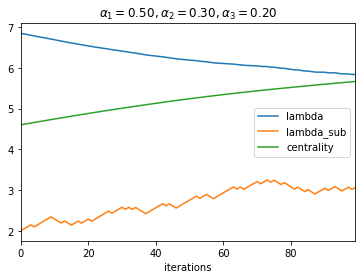

In [8]:
plot_results(results, alphas)

Recall the attacker wants the orange and green lines to increase, while keeping the blue as constant as possible. Here, orange is oscillating and blue is decreasing. One possible reason that orange is oscillating is the following: if many nodes in the target subgraph are neighbors of the node of largest degree, then the third term  of the objective function (increasing subgraph centrality) will try to strengthen those connections to the node of largest degree. On the other hand, the second term (decreasing $\lambda_1$) will try to weaken those connections, as $\lambda_1$ is deeply related to the node of largest degree.

## Plot adjacency matrices

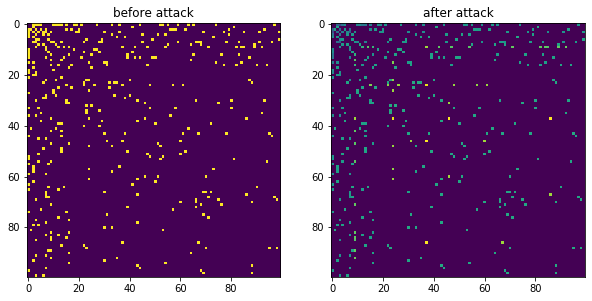

In [9]:
plot_adj_matrices(graph, final_adj)

As before, the weights of most edges have decreased, while the edges incident to (and between) nodes in the subgraph have increased weights. Interestingly, the weights of edges incident to the nodes of largest degree seem to have decreased the most. (I.e. if you look at the top left corner of the right matrix, the colors are darker.) This observation also supports the comment made in the previous plot: even if the target subgraph doesn't include the node of largest degree, its connections to its neighbors tend to be modified substantially (possibly because it is tied to $\lambda_1$).

On the other hand, the intuition that the attacker wants to (broadly) densify the target graph while sparsifying its complement is already visible even with this first pass at the objective function. This lends more support for the sparsification side of things that Sixie and I are looking into.